# Federated learning: deep learning for vertically partitioned data 

In this notebook, we provide a simple example of how to perform a **vertical** federated learning experiment with the help of the Sherpa.ai Federated Learning framework. 
As opposed to the horizontal federated learning paradigm, in a vertical federated learning setting (see e.g. [Federated Machine Learning: Concept and Applications](https://arxiv.org/abs/1902.04885)) the different nodes possess the same samples, but different features. 
A practical example being that of a local on-line shop and an insurance company: both entities might have matching customers (samples), but the information (features) each entity possesses about the customers is of different nature. 
We are going to use a synthetic dataset and a neural network model.


## The data
We use `sklearn` module for generating synthetic databases. 
Moreover, in order to simulate a vertically partitioned training data, we randomly split the features of the created dataset among the clients:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from shfl.private.reproducibility import Reproducibility

# Comment to turn off reproducibility:
Reproducibility(568)

# Create dataset
n_features = 20
n_classes = 2
n_samples = 15000

data, labels = make_classification(
    n_samples=n_samples, n_features=n_features, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, flip_y=0.1, class_sep=0.4, random_state=123)

**Vertical split of the dataset.** In the vertical FL setting, the database is split along the columns (i.e., vertically) among the nodes. 
We can use a method provided by the Sherpa FL Framework to randomly split a dataset vertically into the desired number of parts: 

In [2]:
from shfl.data_base.data_base import vertical_split

# Create a vertically split dataset: split the features among clients
M = 2  # number of clients
train_data, train_labels, test_data, test_labels = \
    vertical_split(data=data, labels=labels)

for item in train_data:
    print("Client train data shape: " + str(item.shape))

Client train data shape: (12000, 11)
Client train data shape: (12000, 9)


**Wrap into FederatedData.** At this point, we assign the data to a federated network of clients. 
Since the clients actually don't possess the labels (only the server does), we assign the client's labels to `None`. 
And since we already performed the split of data for each client, we just use `PlainDataDistribution` to create the wrapper for the federated data (this class converts the data "as is" into a `FederatedData` object):

In [3]:
# Make federated data: 
from shfl.data_base.data_base import LabeledDatabase
from shfl.data_distribution.data_distribution_plain import PlainDataDistribution

clients_labels = [None] * len(train_data) 
data_base = LabeledDatabase(data=train_data, 
                            labels=clients_labels, 
                            train_percentage=1., 
                            shuffle=False) 
data_base.load_data()
federated_data, _, _ = PlainDataDistribution(database=data_base).get_federated_data()
print(federated_data)

**Federated transformation.** In case we need to perform a data transformation on all the clients of the federated data, this is easily achieved by the framework's method: 

In [4]:
# Federated data operation: need to transform to tensors
import torch
import torch.nn as nn

from shfl.private import FederatedTransformation

class FromNumpyFloat(FederatedTransformation):
    
    def apply(self, labeled_data):
        if labeled_data.data is not None:
            labeled_data.data = torch.from_numpy(labeled_data.data).float()
        
federated_data.apply_data_transformation(FromNumpyFloat());

In order to visually check everything went fine with the data assignment, we can configure data access to node (otherwise protected by default):

In [5]:
# Check federated data:
from shfl.private.data import UnprotectedAccess

federated_data.configure_data_access(UnprotectedAccess());
federated_data[0].query()
federated_data[0].query().data.shape
#federated_data[0].query().label

torch.Size([12000, 11])

## The model:

**Horizontal Vs Vertical Federated Learning.** Both in the  Federated Government is interpreted as follows: 
 - The Federated Government is intended as a *Coordinator*: it defines and schedules the federated computations, but does not have any other function (no data, no model). It is what a user can customize for the specific case problem.
 - The Federated Data is composed by nodes that can have multiple functions: train, store data, aggregate, make auxiliary computations, predictions etc.
 - In particular, the Server is itself a *node* that can interact with the Federated Data: it might aggregate, but might also contain data and train on them

In Horizontal FL (see e.g. the [basic concepts notebook](./federated_learning_basic_concepts.ipynb)), all nodes have typically the same model, and the server node has also the aggregation function in its model as an attribute but do not train and does not possess any data.
Instead in a Vertical FL architecture, the client nodes might have a *different model* with respect each other and with respect the server node.
The latter in turn can aggregate, train and might possess its own data (i.e. the labels in this case).

Note that the distinction between client and server is *only virtual* and not necessarily physical, since a single node might be both client and server, allowing multiple roles for the same physical node.   

**Define the server node.** We said that in the Vertical FL, each node, including the server, is allowed to possess a different model and different methods for interacting with the clients.
We here define the server model with specific functions needed for the present Vertical FL architecture.
The server is assigned a linear model, along with the data to train on (only labels, in this specific example): 

In [6]:
from sklearn.metrics import roc_auc_score

from shfl.model.vertical_deep_learning_model import VerticalNeuralNetServer
from shfl.private.federated_operation import VerticalServerDataNode
from shfl.private.data import LabeledData

n_embeddings = 2

model_server = torch.nn.Sequential(
    torch.nn.Linear(n_embeddings, 1, bias=True),
    torch.nn.Sigmoid())

loss_server = torch.nn.BCELoss(reduction="mean")
optimizer_server = torch.optim.SGD(params=model_server.parameters(), lr=0.001)


def roc_auc(y_pred, y_true):
    """
    # Arguments:
        y_pred: Predictions 
        y_true: True labels
    """
    return roc_auc_score(y_true, y_pred)

model = VerticalNeuralNetServer(model_server, loss_server, optimizer_server, 
                                      metrics={"roc_auc": roc_auc})


# Create the server node: 
server_node = VerticalServerDataNode(
    federated_data=federated_data, 
    model=model,
    data=LabeledData(data=None, label=train_labels.reshape(-1,1)))

In [7]:
for layer in model_server.parameters():
    print(layer)

Parameter containing:
tensor([[0.3515, 0.3290]], requires_grad=True)
Parameter containing:
tensor([0.2528], requires_grad=True)


**Define specific data access needed for the Vertical FL round.** The specific Vertical FL architecture requires the computation of the Loss and the exchange of convergence parameters. 
Namely, the clients send the computed embeddings to the server, and the server sends the computed gradients to update the clients. 
Therefore, we define ad-hoc access definitions for these methods, and we assign them to server and clients: 

In [8]:
from shfl.private.data import DataAccessDefinition

class TrainEvaluation(DataAccessDefinition):
    """Evaluate collaborative model on batch train data."""
    def apply(self, data, **kwargs): 
        
        server_model = kwargs.get("server_model")
        embeddings, embeddings_indices = kwargs.get("meta_params")
        labels = data.label[embeddings_indices]
    
        evaluation = server_model.evaluate(embeddings, labels)
        
        return evaluation
    
    
class QueryMetaParameters(DataAccessDefinition):
    """Returns embeddings (or their gradients) as computed by the local model."""
    def apply(self, model, **kwargs):
        return model.get_meta_params(**kwargs)

    
# Configure data access to nodes and server
federated_data.configure_model_access(QueryMetaParameters())
server_node.configure_model_access(QueryMetaParameters())
server_node.configure_data_access(TrainEvaluation())   

print(federated_data[1]._model_access_policy)
print(server_node._model_access_policy)
print(server_node._private_data_access_policies)

{'139919351956704': <__main__.TrainEvaluation object at 0x7f417db514a8>}


## Run the federated learning experiment

We are almost done: we only need to specify which specific model to use for each client node, and the server node. 
Namely, the clients will run a neural network model, but of course they will have different input size since they possess different number of features. 
We first don't use hidden layers for the clients model, resulting in a *linear* model (`layer_dims=None` parameter):

In [9]:
from shfl.model.vertical_deep_learning_model import VerticalNeuralNetClient

model0 = nn.Sequential(
    nn.Linear(train_data[0].shape[1], n_embeddings, bias=True),
)

model1 = nn.Sequential(
    nn.Linear(train_data[1].shape[1], n_embeddings, bias=True),
)

optimizer0 = torch.optim.SGD(params=model0.parameters(), lr=0.001)
optimizer1 = torch.optim.SGD(params=model1.parameters(), lr=0.001)

batch_size = 32
model_nodes = [VerticalNeuralNetClient(model=model0, loss=None, optimizer=optimizer0, batch_size=batch_size),
               VerticalNeuralNetClient(model=model1, loss=None, optimizer=optimizer1, batch_size=batch_size)]

In [10]:
for layer in model0.parameters():
    print(layer)
    
for layer in model1.parameters():
    print(layer)

Parameter containing:
tensor([[ 0.0460,  0.2073,  0.1491, -0.2929, -0.1053, -0.2582,  0.0743, -0.0865,
         -0.1360,  0.1849, -0.2111],
        [-0.1739, -0.2327,  0.0872,  0.1774,  0.1059, -0.0926, -0.1195, -0.1487,
          0.0066, -0.0082,  0.0316]], requires_grad=True)
Parameter containing:
tensor([ 0.1268, -0.1403], requires_grad=True)
Parameter containing:
tensor([[-0.1689, -0.1785, -0.3140,  0.2298,  0.1469, -0.1861,  0.1907,  0.0487,
         -0.3327],
        [-0.0719, -0.0274,  0.0238, -0.0363, -0.0159, -0.2333, -0.2449, -0.1991,
         -0.1758]], requires_grad=True)
Parameter containing:
tensor([ 0.0066, -0.1330], requires_grad=True)


In [11]:
from shfl.federated_government.vertical_federated_government import VerticalFederatedGovernment


# Create federated government and run training:
federated_government = VerticalFederatedGovernment(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

In [12]:
federated_government.run_rounds(n=10001, 
                                test_data=test_data, 
                                test_label=test_labels.reshape(-1,1), 
                                eval_freq=1000)

Round 0
Collaborative model train batch evaluation: [0.6753166317939758, 0.5843137254901961]


/home/goran/Developer/frameworks/python/venv/SherpaFL_py37/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Collaborative model test evaluation: ([0.663094162940979, 0.6649570837577845], None)


Round 1000
Collaborative model train batch evaluation: [0.7088802456855774, 0.5647058823529412]
Collaborative model test evaluation: ([0.6448869109153748, 0.704028597790898], None)


Round 2000
Collaborative model train batch evaluation: [0.5989469289779663, 0.8]
Collaborative model test evaluation: ([0.6248701214790344, 0.7406971844882851], None)


Round 3000
Collaborative model train batch evaluation: [0.6275280714035034, 0.7098039215686274]
Collaborative model test evaluation: ([0.6024484038352966, 0.7733341511241958], None)


Round 4000
Collaborative model train batch evaluation: [0.6383407711982727, 0.6666666666666667]
Collaborative model test evaluation: ([0.5787290930747986, 0.8005821426476156], None)


Round 5000
Collaborative model train batch evaluation: [0.5135955810546875, 0.9019607843137255]
Collaborative model test evaluation: ([0.5548705458641052, 0.8216780357374607], None)


Round 600

In [13]:
pred = np.array([[0.6474936 ],  [0.55246866], [0.5951535 ], [0.45489264]])

true = np.array([[1], [1],  [1], [0]])
roc_auc_score(true, pred)

1.0

**Comparison to Centralized training.** As reference, we can compare the performance of the collaborative model to the centralized training:  

In [14]:
def plot_roc(y_test, y_prediction, save_path=None):
    fpr, tpr, _ = roc_curve(y_test, y_prediction)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(8, 7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if save_path is not None: 
        plt.savefig(save_path, bbox_inches = "tight")
    plt.show()

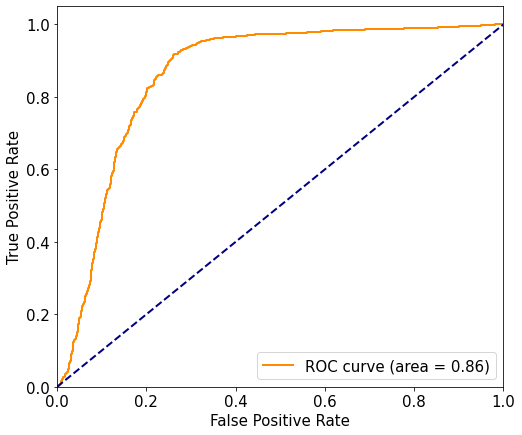

In [15]:
y_prediction = federated_government._server.predict_collaborative_model(test_data)
plot_roc(test_labels, y_prediction)

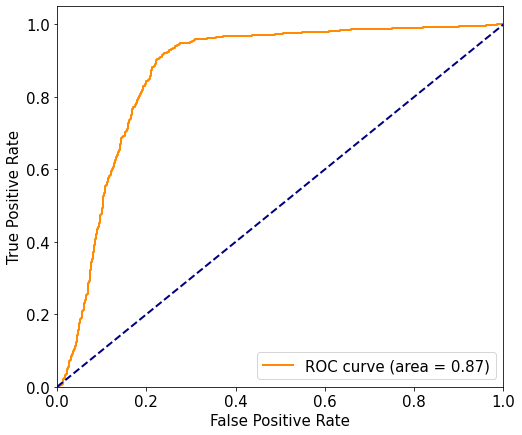

In [16]:
# Linear model Benchmark on centralized data using sk-learn:
#clf_linear = MLPClassifier(hidden_layer_sizes=(1,), max_iter=10000, shuffle=False, random_state=321).fit(x_train, y_train)

centralized_train_data = np.concatenate(train_data, axis=1)
centralized_test_data = np.concatenate(test_data, axis=1)

clf_linear = LogisticRegression(random_state=123).fit(centralized_train_data, train_labels)

y_prediction = clf_linear.predict_proba(centralized_test_data)[:, 1]
plot_roc(test_labels, y_prediction)

**Non-linear model:**

We now add a hidden layer in the clients' neural network model, resulting in a *non-linear* model (parameter `layer_dims=[3]`): 

In [17]:
#from shfl.model.vertical_deep_learning_model import VerticalNeuralNetClient

n_hidden_neurons = 3

model0 = nn.Sequential(
    nn.Linear(train_data[0].shape[1], n_hidden_neurons, bias=True),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, n_embeddings, bias=True)
)

model1 = nn.Sequential(
    nn.Linear(train_data[1].shape[1], n_hidden_neurons, bias=True),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, n_embeddings, bias=True)
)

optimizer0 = torch.optim.SGD(params=model0.parameters(), lr=0.001)
optimizer1 = torch.optim.SGD(params=model1.parameters(), lr=0.001)

batch_size = 32
model_nodes = [VerticalNeuralNetClient(model=model0, loss=None, optimizer=optimizer0, batch_size=batch_size),
               VerticalNeuralNetClient(model=model1, loss=None, optimizer=optimizer1, batch_size=batch_size)]

In [18]:
from shfl.federated_government.vertical_federated_government import VerticalFederatedGovernment


# Create federated government and run training:
federated_government = VerticalFederatedGovernment(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

In [19]:
federated_government.run_rounds(n=150001, 
                                test_data=test_data, 
                                test_label=test_labels.reshape(-1,1), 
                                eval_freq=10000)

Round 0
Collaborative model train batch evaluation: [0.7648593783378601, 0.5450980392156863]
Collaborative model test evaluation: ([0.7186072468757629, 0.5764265561582318], None)


Round 10000
Collaborative model train batch evaluation: [0.4737544059753418, 0.8156862745098039]
Collaborative model test evaluation: ([0.4515281617641449, 0.8718059488951823], None)


Round 20000
Collaborative model train batch evaluation: [0.31809723377227783, 0.9490196078431372]
Collaborative model test evaluation: ([0.40795573592185974, 0.8902040210421145], None)


Round 30000
Collaborative model train batch evaluation: [0.5141854286193848, 0.8823529411764707]
Collaborative model test evaluation: ([0.38956210017204285, 0.902730443687099], None)


Round 40000
Collaborative model train batch evaluation: [0.4602660536766052, 0.8901960784313725]
Collaborative model test evaluation: ([0.3798622190952301, 0.9077580796848307], None)


Round 50000
Collaborative model train batch evaluation: [0.30201780796051025,

In [29]:
print(federated_government._server._model)
print(federated_government._server._model.get_model_params())
print(federated_government._federated_data[0]._model.get_model_params())

[array([[2.3163369, 1.5198019]], dtype=float32), array([0.5661466], dtype=float32)]
[array([[-0.01249968, -0.00998871,  0.02343099,  0.01260444, -0.01731426,
        -0.03544535,  0.00875627, -0.02318165,  0.01772114, -0.01272264,
         0.00477158],
       [ 0.00319104,  0.14554304, -0.20019789, -0.11322974, -0.12234511,
         0.14015083,  0.00216873,  0.12236807, -0.157773  ,  0.10295682,
        -0.03871047],
       [-0.06361531,  0.17583223,  0.04567049, -0.17900583, -0.0104975 ,
         0.16373055, -0.16250864,  0.02143923,  0.13268958,  0.0480644 ,
        -0.22650775]], dtype=float32), array([ 0.45191023, -0.03056407, -0.30394697], dtype=float32), array([[ 0.48991108, -0.0928534 ,  0.4794815 ],
       [ 0.25989947,  0.37519667, -0.47290254]], dtype=float32), array([0.42294413, 0.35341358], dtype=float32)]


As before, we can compare the performance to the analogous centralized model using one hidden layer: 

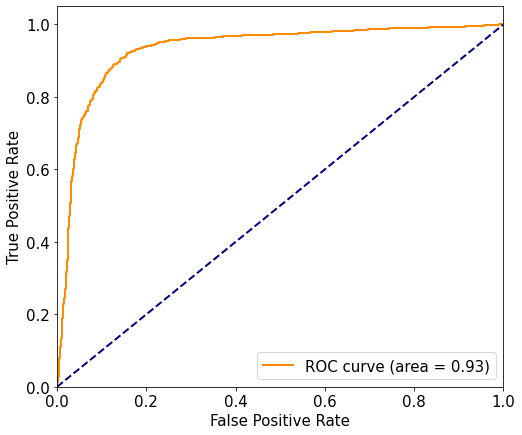

In [21]:
y_prediction = federated_government._server.predict_collaborative_model(test_data)
plot_roc(test_labels, y_prediction)

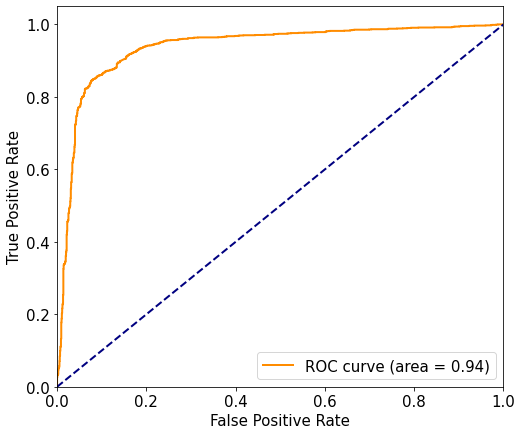

In [22]:
# Non-linear benchmark
clf_non_linear = MLPClassifier(hidden_layer_sizes=(3,), max_iter=10000, 
                               shuffle=False, random_state=3221)
clf_non_linear.fit(centralized_train_data, train_labels)

y_prediction = clf_non_linear.predict_proba(centralized_test_data)[:, 1]
plot_roc(test_labels, y_prediction)